# Deep Learning

Le *Deep Learning* est l'utilisation de *réseaux de neurones* profonds, qui a récemment été rendu par des progrès aussi bien théoriques que techniques.
Il permet d'effectuer des tâches de classifications complexes, notamment dans la reconnaissance d'images, les couches intermédaires apprenant des représentations intermédiaires.

Pour identifier des éléments dans une image (à deux dimensions, donc) et dont la position n'est pas fixée, on utilise des couches qui effectuent des *convolutions* sur des fragments de l'image (*Convnet*).

Ces réseaux de neurones nécessitent souvent des volumes de données importantes et de grosses ressources en temps de calcul (les processeurs des cartes graphiques *GPU* sont utilisés avec profit) et l'on risque le surapprentissage *overfitting* où le réseaux apprend par cœur le jeu d'apprentissage sans être capable de généraliser sur les jeux de validation / test. De nombreuses techniques visent à éviter ou réduire ce sur-apprentissage.

Par ailleurs, les ressources nécessaires à l'entrainement d'un réseaux complexe sur de gros volumes de données rendent pertinente la possibilité de sauvegarder/restaurer non seulement la configuration du réseau mais aussi son paramétrage une fois entrainé. De plus, on voudra autant que possible réutiliser des gros réseaux ayant été paramétré pour une tâche afin d'accomplir des tâches voisines (*transfert learning*).

http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=10&networkShape=8,1&seed=0.58434&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=true&ySquared=true&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false


## Un modèles de classification supervisé

Les réseaux de neurones qui servent au *deep learning* peuvent tout à fait être utilisés comme des modèles classiques de classification supervisée. On peut ainsi reprendre l'exemple classique de pronostic médical de diabète :

In [1]:
import pandas as pd

In [2]:
columns=['pregnancies','glucose', 'blodd_pressure', 'skin_tickness', 'insulin', 'bmi', 'pedigree', 'age','outcome']
diabetes=pd.read_csv("https://gitlab.inria.fr/vrazinin/deep-learning-visualization/raw/master/pima-indians-diabetes.csv",header=None,names=columns, index_col=None)

In [3]:
diabetes

pregnancies  glucose  blodd_pressure  skin_tickness  insulin   bmi  \
0              6      148              72             35        0  33.6   
1              1       85              66             29        0  26.6   
2              8      183              64              0        0  23.3   
3              1       89              66             23       94  28.1   
4              0      137              40             35      168  43.1   
..           ...      ...             ...            ...      ...   ...   
763           10      101              76             48      180  32.9   
764            2      122              70             27        0  36.8   
765            5      121              72             23      112  26.2   
766            1      126              60              0        0  30.1   
767            1       93              70             31        0  30.4   

     pedigree  age  outcome  
0       0.627   50        1  
1       0.351   31        0  
2       0.672   32        1  
3       0.167   21        0  
4       2.288   33        1  
..        ...  ...      ...  
763     0.171   63        0  
764     0.340   27        0  
765     0.245   30        0  
766     0.349   47        1  
767     0.315   23        0  

[768 rows x 9 columns]

In [4]:
(diabetes.loc[:,columns[1:-1]]==0).sum()

glucose             5
blodd_pressure     35
skin_tickness     227
insulin           374
bmi                11
pedigree            0
age                 0
dtype: int64

In [5]:
(diabetes[columns[1:-1]]==0).sum()

glucose             5
blodd_pressure     35
skin_tickness     227
insulin           374
bmi                11
pedigree            0
age                 0
dtype: int64

In [6]:
import numpy as np
for c in columns[1:-1]:
    diabetes[c].replace(0,np.NaN, inplace=True)
(diabetes[columns[1:-1]]==0).sum()

glucose           0
blodd_pressure    0
skin_tickness     0
insulin           0
bmi               0
pedigree          0
age               0
dtype: int64

In [7]:
diabetes.dropna(inplace=True)
diabetes[columns[1:-1]].isnull().sum()

glucose           0
blodd_pressure    0
skin_tickness     0
insulin           0
bmi               0
pedigree          0
age               0
dtype: int64

In [8]:
diabetes.columns

Index(['pregnancies', 'glucose', 'blodd_pressure', 'skin_tickness', 'insulin',
       'bmi', 'pedigree', 'age', 'outcome'],
      dtype='object')

In [9]:
X=diabetes[diabetes.columns.intersection(columns[:-1])].values
y=diabetes['outcome'].values

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X= scaler.transform(X)

In [11]:
X

array([[-0.7174265 , -1.09104581, -0.37365481, ..., -0.710421  ,
        -1.03187632, -0.9682991 ],
       [-1.02921274,  0.46631407, -2.45696436, ...,  1.42673006,
         5.11511079,  0.2095853 ],
       [-0.09385402, -1.44794079, -1.65569146, ..., -0.29723846,
        -0.79712575, -0.47751393],
       ...,
       [-0.40564026, -1.12349081, -1.01467313, ..., -0.66767798,
         0.70411863, -0.87014206],
       [ 2.08864966, -0.70170584,  0.42761809, ..., -0.02653266,
        -1.0202837 ,  3.15429628],
       [ 0.52971846, -0.05280589,  0.10710893, ..., -0.9811268 ,
        -0.80582021, -0.0848858 ]])

In [64]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers

def create_basic_model():
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation= 'relu'))
    model.add(Dense(8, activation= 'relu'))
    model.add(Dense(1, activation= 'sigmoid'))
    return model

def create_generic_model(layers):
    model = Sequential()
    prev_layer= 8
    for n,activation in layers:
        model.add(Dense(n, input_dim=prev_layer, activation= activation))
        prev_layer= n
    model.add(Dense(1, activation= 'sigmoid'))
    return model

def create_dropout_model(layers):
    model = Sequential()
    prev_layer= 8
    for n,activation in layers:
        model.add(Dense(n, input_dim=prev_layer, activation= activation))
        if(n==16):
            model.add(Dropout(0.5))
        prev_layer= n
    model.add(Dense(1, activation= 'sigmoid'))
    return model

def create_reg_model(layers):
    model = Sequential()
    prev_layer= 8
    for n,activation in layers:
        model.add(Dense(n, input_dim=prev_layer, activation= activation, kernel_regularizer= regularizers.l2(0.001)))
        model.add(Dropout(0.3))
        prev_layer= n
    model.add(Dense(1, activation= 'sigmoid'))
    return model


model= create_generic_model([(12,'relu'),(8,'relu'),(1,'relu')])

In [65]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 12)                108       
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 2         
Total params: 223
Trainable params: 223
Non-trainable params: 0
_________________________________________________________________


[compter le nombre de paramètres](https://towardsdatascience.com/counting-no-of-parameters-in-deep-learning-models-by-hand-8f1716241889)

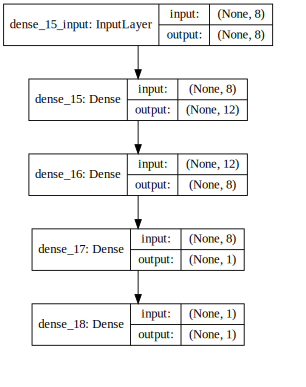

In [66]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

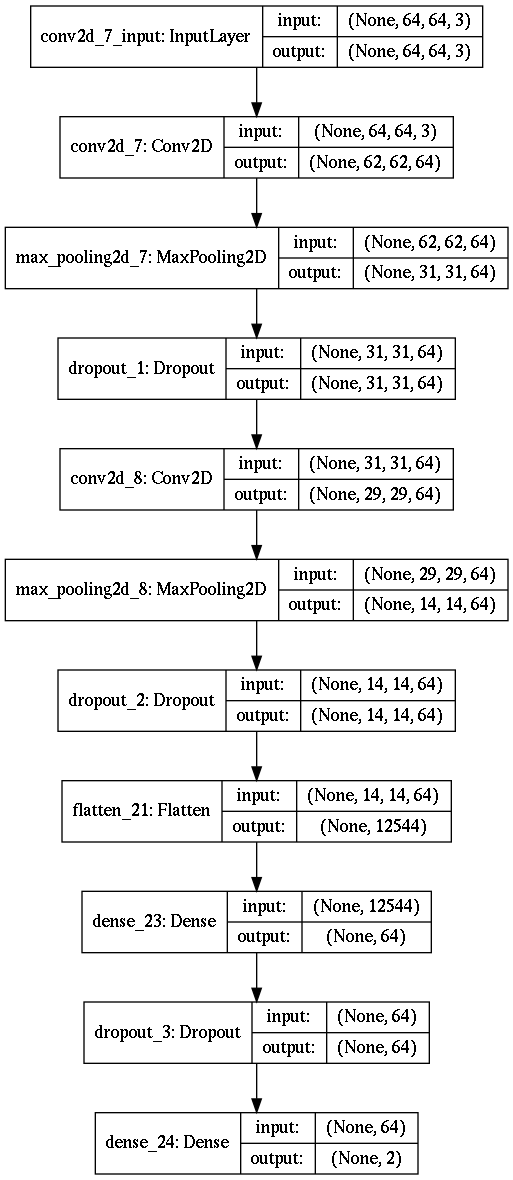

In [232]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [67]:
model.compile(loss= 'binary_crossentropy', optimizer= 'adam' , metrics=['accuracy'])

In [68]:
model.fit(X, y, epochs=150, batch_size=16)

Epoch 1/150
392/392 [==============================] - 1s 2ms/step - loss: 0.6917 - accuracy: 0.6480
Epoch 2/150
392/392 [==============================] - 0s 516us/step - loss: 0.6869 - accuracy: 0.6888
Epoch 3/150
392/392 [==============================] - 0s 493us/step - loss: 0.6819 - accuracy: 0.7194
Epoch 4/150
392/392 [==============================] - 0s 726us/step - loss: 0.6762 - accuracy: 0.7245
Epoch 5/150
392/392 [==============================] - 0s 539us/step - loss: 0.6687 - accuracy: 0.7423
Epoch 6/150
392/392 [==============================] - 0s 680us/step - loss: 0.6607 - accuracy: 0.7602
Epoch 7/150
392/392 [==============================] - 0s 499us/step - loss: 0.6533 - accuracy: 0.7628
Epoch 8/150
392/392 [==============================] - 0s 516us/step - loss: 0.6448 - accuracy: 0.7755
Epoch 9/150
392/392 [==============================] - 0s 750us/step - loss: 0.6364 - accuracy: 0.7832
Epoch 10/150
392/392 [==============================] - 0s 943us/step - los

In [57]:
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

392/392 [==============================] - 0s 442us/step
Accuracy: 80.61


**Exercice :** Relancer les construction du modèle, sa compilation, son entrainement et son évaluation. Est-ce que les résultats sont les mêmes ? Quelles conclusions en tirer ?

**Exercice :** Entrainer le modèle sur un jeu de d'apprentissage et l'évaluer sur un jeu de test.

In [58]:
from sklearn.model_selection import StratifiedShuffleSplit
def evaluate_model(model, X, y, n_epochs=10, n_splits=1):
    histories= []
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5, random_state=42)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        histories.append(model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0))
    return histories

In [59]:
h= evaluate_model(model,X,y,200)

In [60]:
history= h[0].history
xx=range(1,len(history['loss'])+1)
h[0].history.keys()
(acc,val_acc)= ('acc','val_acc') if 'acc' in history.keys() else ('accuracy', 'val_accuracy')

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("notebook")

In [114]:
import pandas as pd

In [165]:
def plot_loss_acc(history):
    (acc,val_acc)= ('acc','val_acc') if 'acc' in history.keys() else ('accuracy', 'val_accuracy')
    df=pd.DataFrame({'epoch': range(1,len(history['loss'])+1)
                    ,'loss apprentissage' : history['loss']
                    ,'loss validation' : history['val_loss']
                    ,'accuracy apprentissage' : history[acc]
                    ,'accuracy validation' : history[val_acc]})
    df=df.melt(id_vars=['epoch'])
    tmp = df["variable"].str.split(" ", n = 1, expand = True) 
    df["metric"]= tmp[0] 
    df["data"]= tmp[1] 
    df.drop(columns =["variable"], inplace = True)
    sns.relplot(x='epoch', y='value',hue='data', col='metric', data=df, kind="line")

In [186]:
def plot_loss_acc(history):
    acc= 'acc' if 'acc' in history.keys() else 'accuracy'
    for metric in ('loss', acc):
        df=pd.DataFrame({'epoch': range(1,len(history['loss'])+1)
                    ,metric+' apprentissage' : history[metric]
                    ,metric+' validation' : history['val_'+metric]})
        df=df.melt(id_vars=['epoch'], var_name='data', value_name=metric)
        sns.relplot(x='epoch', y=metric,hue='data', data=df, kind="line", height=10, aspect=1.3)

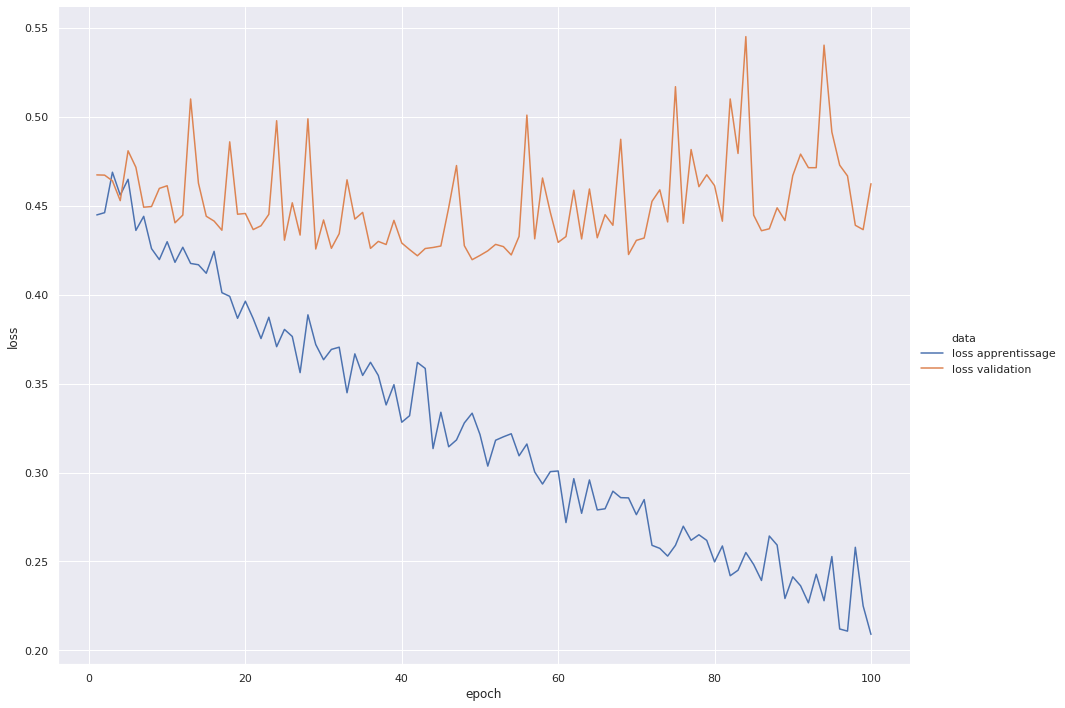

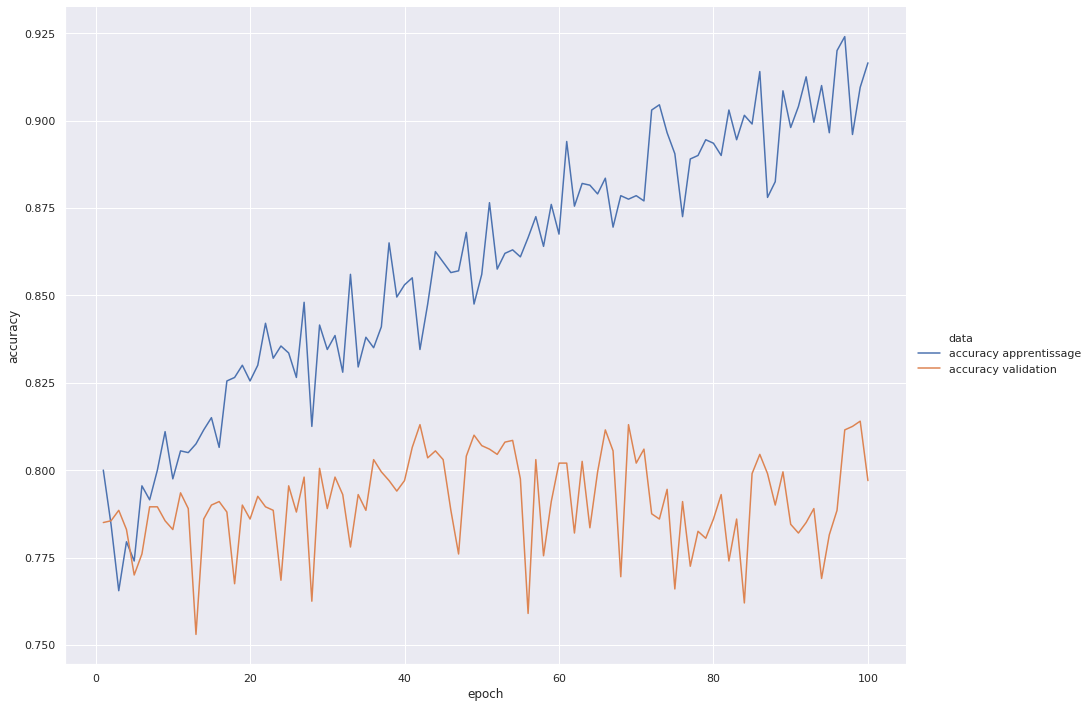

In [187]:
plot_loss_acc(history_transfert)

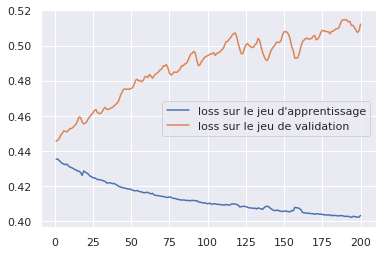

In [62]:
sns.lineplot(x=xx, y=history['loss'])
sns.lineplot(x=xx, y=history['val_loss'])
plt.legend(["loss sur le jeu d'apprentissage", "loss sur le jeu de validation"])

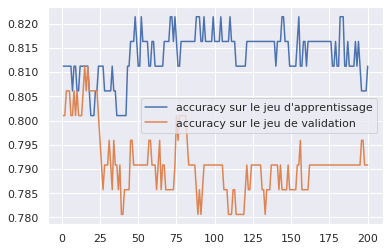

In [63]:
sns.lineplot(x=xx, y=history[acc])
sns.lineplot(x=xx, y=history[val_acc])
plt.legend(["accuracy sur le jeu d'apprentissage", "accuracy sur le jeu de validation"])

**Exercice :** Utiliser l'argument `n_splits` de `evaluate_model` pour visualiser l'intervalle de confiance sur ces indicateurs.

In [27]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_basic_model_and_compile(optimizer= 'rmsprop', init= 'glorot_uniform' ):
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation= 'relu'))
    model.add(Dense(8, activation= 'relu'))
    model.add(Dense(1, activation= 'sigmoid'))
    model.compile(loss= 'binary_crossentropy', optimizer= 'adam' , metrics=['accuracy'])
    return model

model_opt = KerasClassifier(build_fn=create_basic_model_and_compile, verbose=0)
optimizers = ['rmsprop', 'adam']
inits = [ 'glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=inits)
grid = GridSearchCV(estimator=model_opt, param_grid=param_grid, cv=3, scoring="accuracy", verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/bernard/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  5.0min finished


# Sur apprentissage :

Bcp de données de structure complexe → réseaux complexe pour apprendre la structure mais pb de sur apprentissage
→ drop out (propagation aléatoire)
→ régularisation (pénalisation des poids)
→ augmentation de données (génération de données)
→ arrêt prématuré (*early stopping*)

## Dropout

En général, on utilise un *dropout* de 20%-50%. Trop faible, le *dropout* n'est pas capable d'éviter le surapprentissage, (c'est-à-dire la hausse du *loss* en validation),trop fort, il empêche l'apprentissage (rendant aléatoire l'évolution du *loss* en apprentissage).


Par ailleurs, le *dropout* est le plus utile avec des réseaux de grande taille car ceux-ci ont plus de possibilités pour apprendre différentes représentations indépendantes des données, celles-ci pouvant compenser les imprécisions, liées au *dropout*,  de chacune.


On utilise souvent du *dropout* sur les différentes couches, y compris la couche d'entrées ('visible').

Le *dropout* est souvent utilisés avec une grande vitesse d'apprentissage (mais décroissante: *decay*) avec une grande inertie *momentum*, par exemple de 0.9 à 0.99.

## Régularisation

Pour éviter le surapprentissage, il est aussi utile de limiter l'importance que peuvent prendre les poids ([contraints](https://keras.io/constraints/), pour éviter que certains poids puissent prendre un importance démesurée. C'est particulièrement utile lorsque la vitesse d'apprentissage est grande (cf. supra *dropout*).

## Augmentation de données

Le surapprentissage est souvent lié au volume limité du jeu de données en apprentissage qui est appris 'par cœur'. Une solution naturelle et donc d'augmenter le jeu de données en apprentissage. C'est réalisable lorsque les données à classifier présentent des *invariants*. Par exemple pour des images, on a des invariances d'échelles, de translation et de rotations (sauf [exceptions !](https://www.reddit.com/r/dataisbeautiful/comments/aydqig/is_it_a_duck_or_a_rabbit_for_google_cloud_vision/)). 

Grâce à la classe [keras.preprocessing.image.ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class), on peut générer automatiquement des données en transformant les données initiales. Il est important de noter que la génération est **dynamique** c'est-à-dire que chaque *epoch* de l'apprentissage voit de nouvelles données générées à la volée et ne peut donc pas apprendre par cœur. Comme les images sont générées dynamiquement lors de l'apprentissage, il faut aussi que le générateur d'images effectue les prétraitements nécessaires.


## Arrêt prématuré

Finalement, si le problème du sur apprentissage fait que l'erreur en validation augmente lorsque l'on continue à aprrendre, une solution évidente est d'interrompre l'apprentissage lorsque cette erreur augmente. La classe [keras.callbacks.EarlyStopping](https://keras.io/callbacks/#earlystopping) permet de surveiller une métrique (par défaut le *loss* en validation) pour provoquer un arrêt lorsque celle-ci n'évolue plus dans le sens voulu.


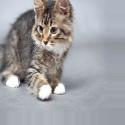

In [35]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
import urllib
from io import BytesIO
from IPython.display import Image

URL = "https://www.lehavre.fr/sites/default/files/styles/miniature_landing/public/thumbnails/image/chat.jpg"
with urllib.request.urlopen(URL) as url:
    image = load_img(BytesIO(url.read()), target_size=(125, 125))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    idg = ImageDataGenerator(rotation_range=30,
                             zoom_range=0.15,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.15,
                             horizontal_flip=True,
                             fill_mode="nearest")
    images = idg.flow(image, batch_size=1, save_to_dir='.', save_prefix="generated_", save_format="jpg")

    i = 0
    n =10

    for image in images:
        i += 1
        if i == n:
            break
Image("generated__0_2780.jpg")

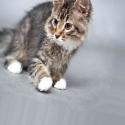

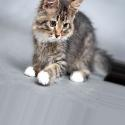

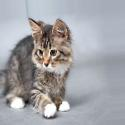

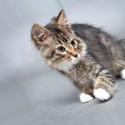

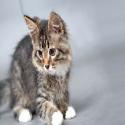

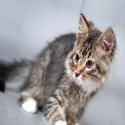

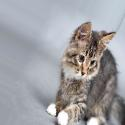

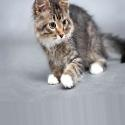

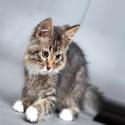

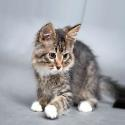

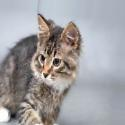

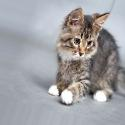

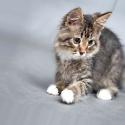

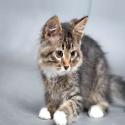

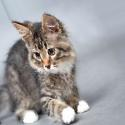

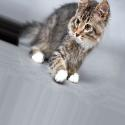

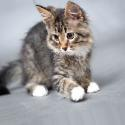

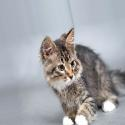

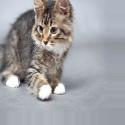

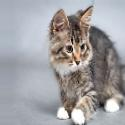

In [38]:
from IPython.display import Image, display
import glob
image_files=[Image(f) for f in glob.glob("generated_*.jpg")]

display(*image_files)

In [8]:
import glob
imagePaths = list(glob.glob("Data/dogs_vs_cats_small_64x64/*/*"))
imagePaths

['Data/dogs_vs_cats_small_64x64/dogs/dogs_00880.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00827.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00164.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00577.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00114.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00846.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00299.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00410.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00774.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00851.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00152.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00362.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00692.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00714.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00572.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00305.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00557.jpg',
 'Data/dogs_vs_cats_small_64x64/dogs/dogs_00885.jpg',
 'Data/dogs_vs_cats_small_64

In [112]:
len(imagePaths)

2000

In [42]:
from keras.preprocessing.image import load_img
import os
import numpy as np
X = []
y = []
for imagePath in imagePaths:
    X.append(np.array(load_img(imagePath, target_size=(64, 64))))
    y.append(imagePath.split(os.path.sep)[-2])

In [115]:
len(y)

2000

In [43]:
X = np.array(X, dtype="float") / 255.0

In [44]:
X.shape

(2000, 64, 64, 3)

In [45]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)
y = np_utils.to_categorical(y, 2)

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.25, random_state=42)

In [152]:
X.shape

(2000, 64, 64, 3)

In [46]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.optimizers import SGD
import keras.backend

def build_basic_conv_model(width, height, depth, classes):
    (input_shape, chan_dim) = ((depth, height, width), 1) if keras.backend.image_data_format() == "channels_first" \
    else ((height, width, depth), -1)
    model = Sequential()
    model.add(Conv2D(64,(3,3), activation = 'relu', input_shape = input_shape))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(64,(3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(classes, activation='sigmoid'))
    return model

In [47]:
model= build_basic_conv_model(64, 64,3,  2)
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [48]:
from sklearn.model_selection import StratifiedShuffleSplit
def evaluate_model(model, X, y, n_epochs=10, n_splits=1):
    histories= []
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5, random_state=42)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        histories.append(model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=1))
    return histories

In [49]:
h= evaluate_model(model,X,y,20)

Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6938 - accuracy: 0.5160 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/20
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6930 - accuracy: 0.4955 - val_loss: 0.6909 - val_accuracy: 0.5310
Epoch 3/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6795 - accuracy: 0.5715 - val_loss: 0.7652 - val_accuracy: 0.5275
Epoch 4/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6781 - accuracy: 0.5625 - val_loss: 0.6702 - val_accuracy: 0.5945
Epoch 5/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6204 - accuracy: 0.6630 - val_loss: 0.6887 - val_accuracy: 0.5815
Epoch 6/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5763 - accuracy: 0.6975 - val_loss: 0.6649 - val_accuracy: 0.6280
Epoch 7/20
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5152 - acc

In [17]:
history= h[0].history
xx=range(1,len(history['loss'])+1)
h[0].history.keys()
(acc,val_acc)= ('acc','val_acc') if 'acc' in history.keys() else ('accuracy', 'val_accuracy')

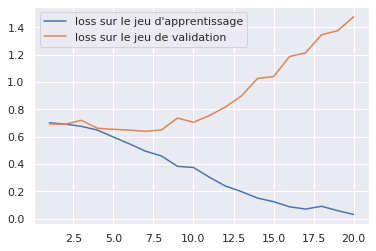

In [20]:
sns.lineplot(x=xx, y=history['loss'])
sns.lineplot(x=xx, y=history['val_loss'])
plt.legend(["loss sur le jeu d'apprentissage", "loss sur le jeu de validation"])

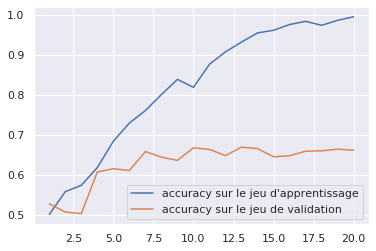

In [21]:
sns.lineplot(x=xx, y=history[acc])
sns.lineplot(x=xx, y=history[val_acc])
plt.legend(["accuracy sur le jeu d'apprentissage", "accuracy sur le jeu de validation"])

In [24]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

**Exercice :** Tester l'impact du paramètre ```zca_whitening=True```.

In [25]:
def evaluate_model_with_generator(model, X, y, generator, n_epochs=10, n_splits=1):
    histories= []
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5, random_state=42)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        histories.append(
            model.fit_generator(generator.flow(X_train, y_train, batch_size=32), epochs=n_epochs,
                                               validation_data=(X_test, y_test), verbose=1))
    return histories

In [26]:
h_gen= evaluate_model_with_generator(model,X,y, generator, 20)

Epoch 1/20
32/32 [==============================] - 5s 168ms/step - loss: 0.8056 - accuracy: 0.5845 - val_loss: 0.6893 - val_accuracy: 0.5000
Epoch 2/20
32/32 [==============================] - 6s 179ms/step - loss: 0.6860 - accuracy: 0.5000 - val_loss: 0.6855 - val_accuracy: 0.5000
Epoch 3/20
32/32 [==============================] - 5s 166ms/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6880 - val_accuracy: 0.5000
Epoch 4/20
32/32 [==============================] - 6s 172ms/step - loss: 0.6890 - accuracy: 0.5070 - val_loss: 0.6863 - val_accuracy: 0.5585
Epoch 5/20
32/32 [==============================] - 7s 205ms/step - loss: 0.6886 - accuracy: 0.5500 - val_loss: 0.6653 - val_accuracy: 0.5900
Epoch 6/20
32/32 [==============================] - 6s 180ms/step - loss: 0.6805 - accuracy: 0.5655 - val_loss: 0.6499 - val_accuracy: 0.6435
Epoch 7/20
32/32 [==============================] - 5s 164ms/step - loss: 0.6528 - accuracy: 0.6135 - val_loss: 0.6374 - val_accuracy: 0.6665
Epoch 

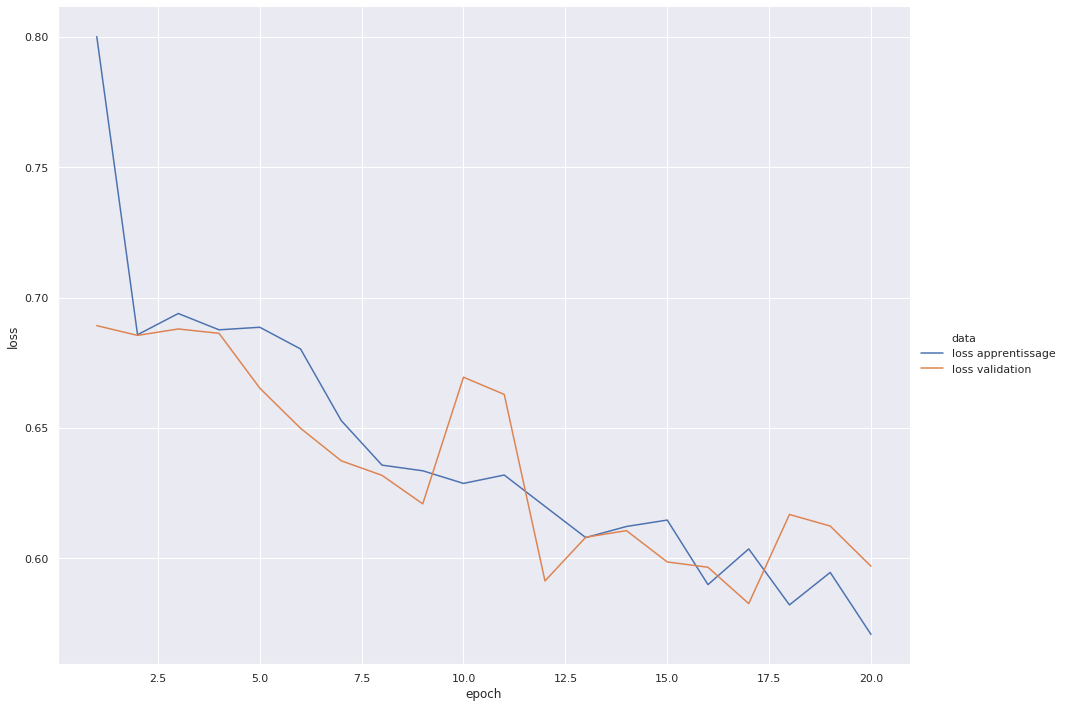

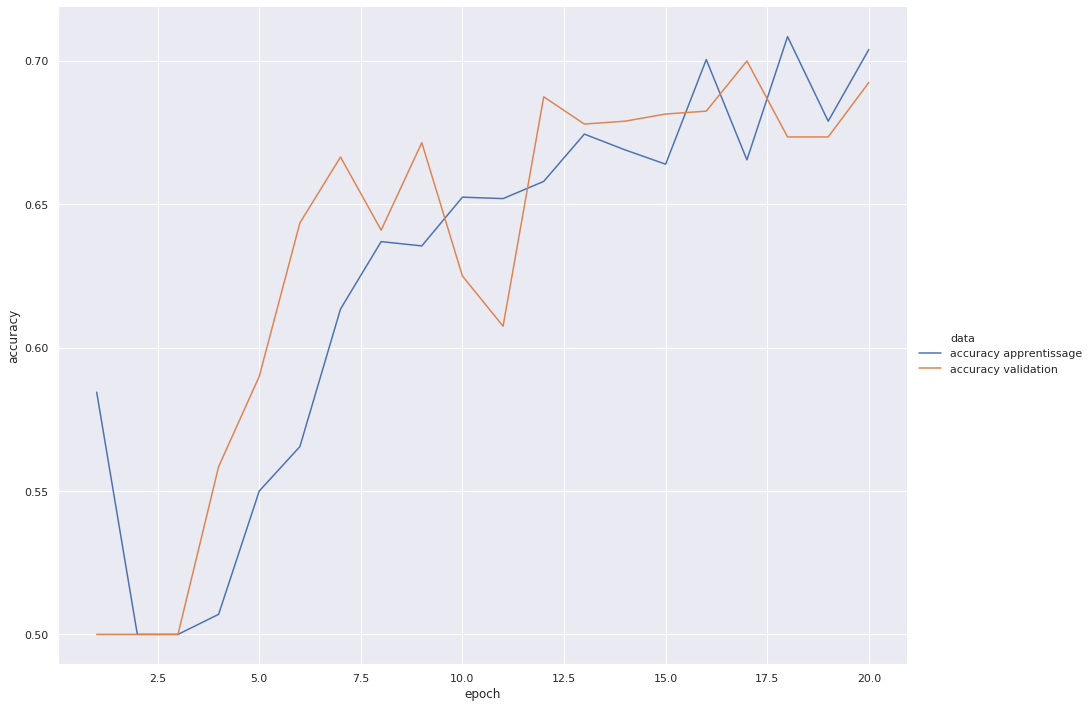

In [188]:
plot_loss_acc(h_gen[0].history)

In [30]:
h_gen_200= evaluate_model_with_generator(model,X,y, generator, 200)

Epoch 1/200
32/32 [==============================] - 6s 180ms/step - loss: 0.5726 - accuracy: 0.7010 - val_loss: 0.7545 - val_accuracy: 0.6295
Epoch 2/200
32/32 [==============================] - 6s 174ms/step - loss: 0.5638 - accuracy: 0.7040 - val_loss: 0.5874 - val_accuracy: 0.6980
Epoch 3/200
32/32 [==============================] - 7s 205ms/step - loss: 0.5640 - accuracy: 0.7055 - val_loss: 0.6757 - val_accuracy: 0.6405
Epoch 4/200
32/32 [==============================] - 6s 200ms/step - loss: 0.5616 - accuracy: 0.7025 - val_loss: 0.5868 - val_accuracy: 0.7015
Epoch 5/200
32/32 [==============================] - 6s 191ms/step - loss: 0.5591 - accuracy: 0.7150 - val_loss: 0.6586 - val_accuracy: 0.6655
Epoch 6/200
32/32 [==============================] - 7s 210ms/step - loss: 0.5687 - accuracy: 0.7215 - val_loss: 0.6011 - val_accuracy: 0.6895
Epoch 7/200
32/32 [==============================] - 6s 176ms/step - loss: 0.5727 - accuracy: 0.7115 - val_loss: 0.5997 - val_accuracy: 0.6835

Epoch 58/200
32/32 [==============================] - 6s 177ms/step - loss: 0.4040 - accuracy: 0.8170 - val_loss: 0.5778 - val_accuracy: 0.7315
Epoch 59/200
32/32 [==============================] - 5s 163ms/step - loss: 0.4238 - accuracy: 0.8000 - val_loss: 0.5706 - val_accuracy: 0.7300
Epoch 60/200
32/32 [==============================] - 6s 172ms/step - loss: 0.4095 - accuracy: 0.7995 - val_loss: 0.6189 - val_accuracy: 0.7330
Epoch 61/200
32/32 [==============================] - 6s 174ms/step - loss: 0.4058 - accuracy: 0.8075 - val_loss: 0.6182 - val_accuracy: 0.7275
Epoch 62/200
32/32 [==============================] - 6s 193ms/step - loss: 0.4375 - accuracy: 0.7915 - val_loss: 0.5598 - val_accuracy: 0.7345
Epoch 63/200
32/32 [==============================] - 5s 166ms/step - loss: 0.4216 - accuracy: 0.7905 - val_loss: 0.7205 - val_accuracy: 0.6910
Epoch 64/200
32/32 [==============================] - 7s 205ms/step - loss: 0.4037 - accuracy: 0.8080 - val_loss: 0.5865 - val_accuracy:

Epoch 115/200
32/32 [==============================] - 5s 162ms/step - loss: 0.3389 - accuracy: 0.8445 - val_loss: 0.6468 - val_accuracy: 0.7310
Epoch 116/200
32/32 [==============================] - 5s 169ms/step - loss: 0.3335 - accuracy: 0.8535 - val_loss: 0.6927 - val_accuracy: 0.7255
Epoch 117/200
32/32 [==============================] - 5s 163ms/step - loss: 0.3227 - accuracy: 0.8590 - val_loss: 0.6759 - val_accuracy: 0.7380
Epoch 118/200
32/32 [==============================] - 5s 162ms/step - loss: 0.3056 - accuracy: 0.8630 - val_loss: 0.6718 - val_accuracy: 0.7475
Epoch 119/200
32/32 [==============================] - 5s 161ms/step - loss: 0.3301 - accuracy: 0.8570 - val_loss: 0.6338 - val_accuracy: 0.7405
Epoch 120/200
32/32 [==============================] - 5s 166ms/step - loss: 0.3239 - accuracy: 0.8620 - val_loss: 0.6779 - val_accuracy: 0.7270
Epoch 121/200
32/32 [==============================] - 7s 207ms/step - loss: 0.3278 - accuracy: 0.8550 - val_loss: 0.6823 - val_ac

32/32 [==============================] - 5s 169ms/step - loss: 0.2776 - accuracy: 0.8785 - val_loss: 0.7633 - val_accuracy: 0.7380
Epoch 172/200
32/32 [==============================] - 5s 169ms/step - loss: 0.2446 - accuracy: 0.8930 - val_loss: 0.8038 - val_accuracy: 0.7210
Epoch 173/200
32/32 [==============================] - 6s 201ms/step - loss: 0.2368 - accuracy: 0.8915 - val_loss: 0.7339 - val_accuracy: 0.7495
Epoch 174/200
32/32 [==============================] - 6s 180ms/step - loss: 0.2485 - accuracy: 0.8870 - val_loss: 0.7456 - val_accuracy: 0.7375
Epoch 175/200
32/32 [==============================] - 6s 197ms/step - loss: 0.2831 - accuracy: 0.8790 - val_loss: 0.7517 - val_accuracy: 0.7370
Epoch 176/200
32/32 [==============================] - 6s 199ms/step - loss: 0.2357 - accuracy: 0.9010 - val_loss: 0.7700 - val_accuracy: 0.7245
Epoch 177/200
32/32 [==============================] - 6s 188ms/step - loss: 0.2836 - accuracy: 0.8805 - val_loss: 0.7577 - val_accuracy: 0.7305

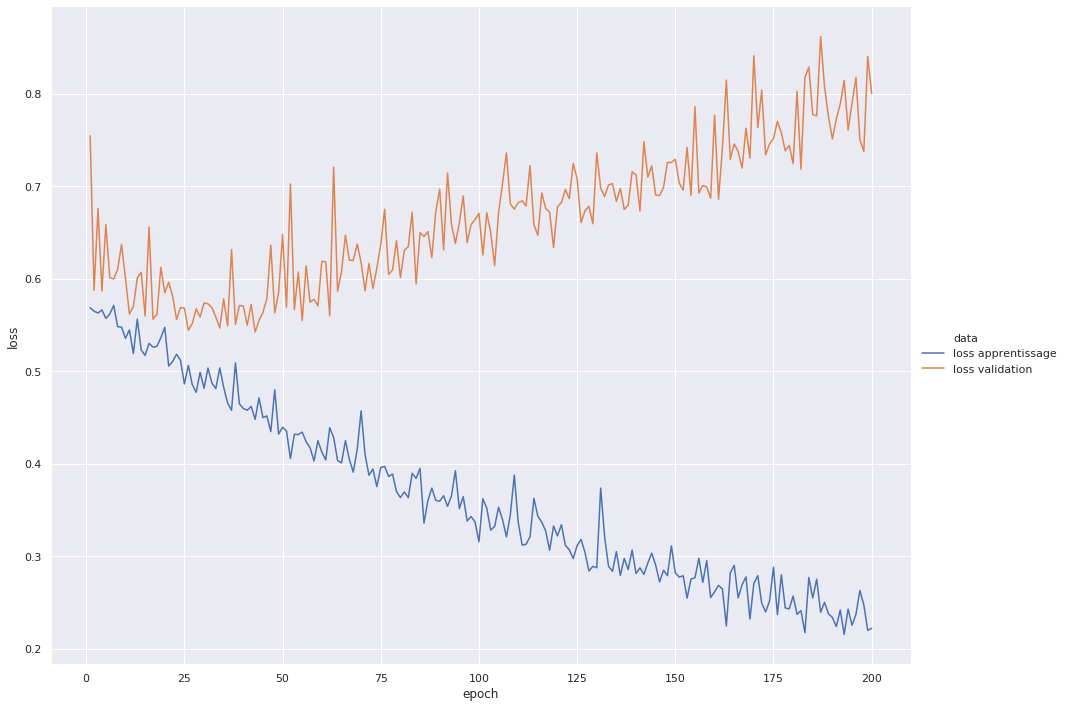

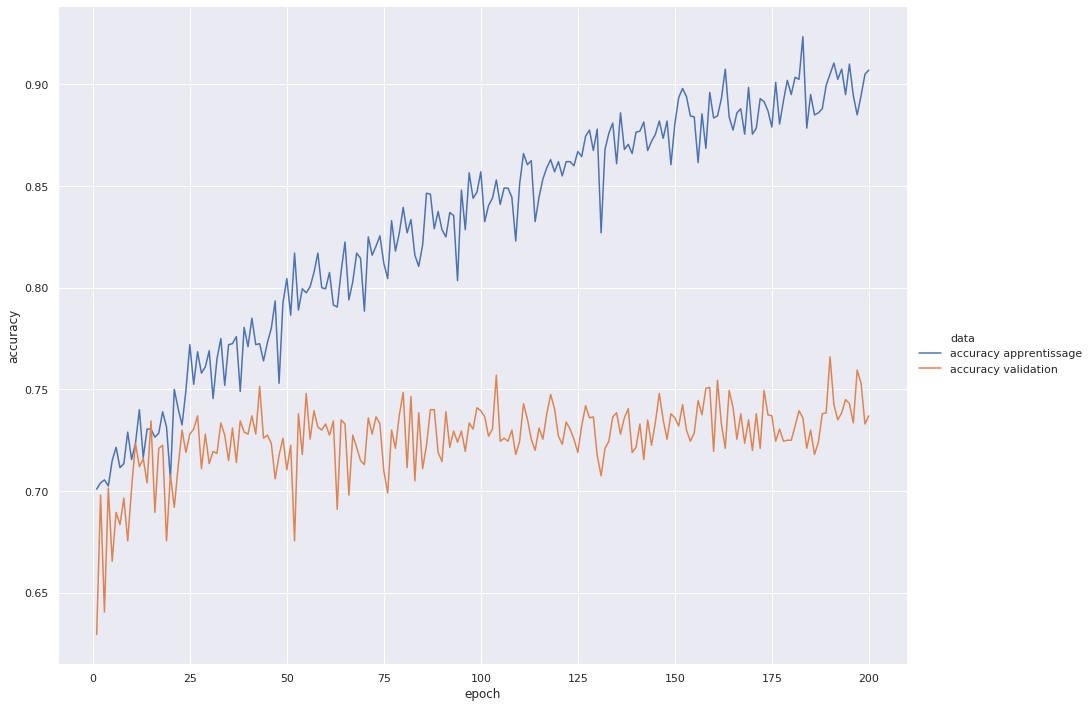

In [189]:
plot_loss_acc(h_gen_200[0].history)

In [190]:
def build_dropout_conv_model(width, height, depth, classes):
    (input_shape, chan_dim) = ((depth, height, width), 1) if keras.backend.image_data_format() == "channels_first" \
    else ((height, width, depth), -1)
    model = Sequential()
    model.add(Conv2D(64,(3,3), activation = 'relu', input_shape = input_shape))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64,(3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation='sigmoid'))
    return model

In [191]:
model= build_dropout_conv_model(64, 64,3,  2)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [192]:
h_dropout_gen_200= evaluate_model_with_generator(model,X,y, generator, 200)

Epoch 1/200
32/32 [==============================] - 7s 224ms/step - loss: 0.7077 - accuracy: 0.5110 - val_loss: 0.6930 - val_accuracy: 0.5065
Epoch 2/200
32/32 [==============================] - 7s 208ms/step - loss: 0.6918 - accuracy: 0.5285 - val_loss: 0.6920 - val_accuracy: 0.5230
Epoch 3/200
32/32 [==============================] - 6s 172ms/step - loss: 0.6935 - accuracy: 0.5405 - val_loss: 0.6881 - val_accuracy: 0.5640
Epoch 4/200
32/32 [==============================] - 6s 176ms/step - loss: 0.6916 - accuracy: 0.5175 - val_loss: 0.6897 - val_accuracy: 0.5445
Epoch 5/200
32/32 [==============================] - 6s 180ms/step - loss: 0.6852 - accuracy: 0.5340 - val_loss: 0.6782 - val_accuracy: 0.5940
Epoch 6/200
32/32 [==============================] - 5s 170ms/step - loss: 0.6844 - accuracy: 0.5505 - val_loss: 0.6758 - val_accuracy: 0.5975
Epoch 7/200
32/32 [==============================] - 7s 227ms/step - loss: 0.6815 - accuracy: 0.5580 - val_loss: 0.6775 - val_accuracy: 0.6075

Epoch 58/200
32/32 [==============================] - 8s 248ms/step - loss: 0.5967 - accuracy: 0.6830 - val_loss: 0.5798 - val_accuracy: 0.6830
Epoch 59/200
32/32 [==============================] - 6s 187ms/step - loss: 0.5773 - accuracy: 0.6890 - val_loss: 0.6018 - val_accuracy: 0.6775
Epoch 60/200
32/32 [==============================] - 7s 223ms/step - loss: 0.5682 - accuracy: 0.6825 - val_loss: 0.5798 - val_accuracy: 0.6820
Epoch 61/200
32/32 [==============================] - 6s 199ms/step - loss: 0.5849 - accuracy: 0.6970 - val_loss: 0.6238 - val_accuracy: 0.6460
Epoch 62/200
32/32 [==============================] - 7s 210ms/step - loss: 0.5721 - accuracy: 0.7120 - val_loss: 0.5910 - val_accuracy: 0.6680
Epoch 63/200
32/32 [==============================] - 7s 216ms/step - loss: 0.5842 - accuracy: 0.6935 - val_loss: 0.5904 - val_accuracy: 0.6960
Epoch 64/200
32/32 [==============================] - 7s 213ms/step - loss: 0.5581 - accuracy: 0.7220 - val_loss: 0.6576 - val_accuracy:

Epoch 115/200
32/32 [==============================] - 6s 197ms/step - loss: 0.4894 - accuracy: 0.7500 - val_loss: 0.5895 - val_accuracy: 0.7270
Epoch 116/200
32/32 [==============================] - 7s 221ms/step - loss: 0.5296 - accuracy: 0.7405 - val_loss: 0.5404 - val_accuracy: 0.7230
Epoch 117/200
32/32 [==============================] - 8s 240ms/step - loss: 0.4950 - accuracy: 0.7505 - val_loss: 0.5402 - val_accuracy: 0.7230
Epoch 118/200
32/32 [==============================] - 7s 226ms/step - loss: 0.4911 - accuracy: 0.7595 - val_loss: 0.5772 - val_accuracy: 0.6965
Epoch 119/200
32/32 [==============================] - 8s 263ms/step - loss: 0.5141 - accuracy: 0.7710 - val_loss: 0.5736 - val_accuracy: 0.7225
Epoch 120/200
32/32 [==============================] - 9s 288ms/step - loss: 0.4992 - accuracy: 0.7490 - val_loss: 0.5388 - val_accuracy: 0.7170
Epoch 121/200
32/32 [==============================] - 8s 251ms/step - loss: 0.5008 - accuracy: 0.7595 - val_loss: 0.6068 - val_ac

32/32 [==============================] - 7s 213ms/step - loss: 0.4840 - accuracy: 0.7810 - val_loss: 0.5370 - val_accuracy: 0.7210
Epoch 172/200
32/32 [==============================] - 6s 199ms/step - loss: 0.4457 - accuracy: 0.7700 - val_loss: 0.6014 - val_accuracy: 0.7105
Epoch 173/200
32/32 [==============================] - 7s 209ms/step - loss: 0.4628 - accuracy: 0.7610 - val_loss: 0.5566 - val_accuracy: 0.7195
Epoch 174/200
32/32 [==============================] - 7s 210ms/step - loss: 0.4144 - accuracy: 0.7910 - val_loss: 0.6256 - val_accuracy: 0.7150
Epoch 175/200
32/32 [==============================] - 6s 196ms/step - loss: 0.4485 - accuracy: 0.7780 - val_loss: 0.5753 - val_accuracy: 0.7170
Epoch 176/200
32/32 [==============================] - 6s 197ms/step - loss: 0.4354 - accuracy: 0.8000 - val_loss: 0.5748 - val_accuracy: 0.7260
Epoch 177/200
32/32 [==============================] - 7s 203ms/step - loss: 0.4519 - accuracy: 0.7905 - val_loss: 0.5784 - val_accuracy: 0.7270

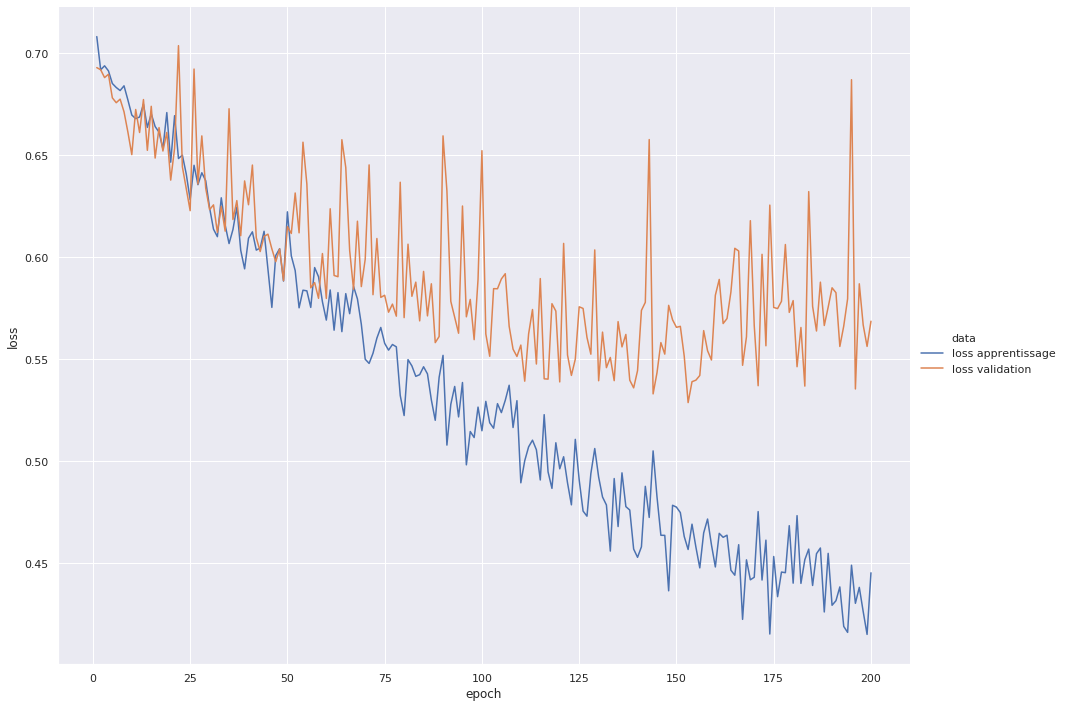

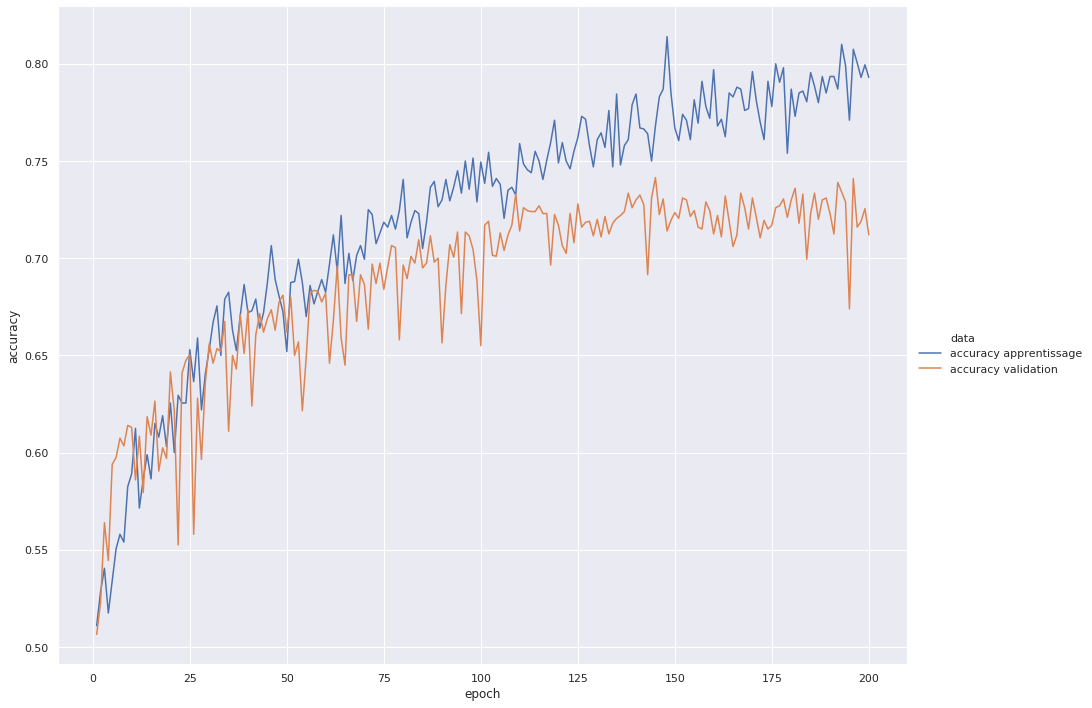

In [193]:
plot_loss_acc(h_dropout_gen_200[0].history)

In [222]:
from keras.regularizers import l2
def build_dropout_reg_conv_model(width, height, depth, classes):
    (input_shape, chan_dim) = ((depth, height, width), 1) if keras.backend.image_data_format() == "channels_first" \
    else ((height, width, depth), -1)
    model = Sequential()
    model.add(Conv2D(64,(3,3), activation = 'relu', input_shape = input_shape, activity_regularizer=l2(0.0001)))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64,(3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation='sigmoid'))
    return model

In [223]:
model_reg= build_dropout_reg_conv_model(64, 64,3,  2)
model_reg.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [224]:
h_reg_gen_200= evaluate_model_with_generator(model_reg,X,y, generator, 200)

Epoch 1/200
32/32 [==============================] - 8s 255ms/step - loss: 2.5443 - accuracy: 0.4965 - val_loss: 0.7029 - val_accuracy: 0.5055
Epoch 2/200
32/32 [==============================] - 7s 213ms/step - loss: 0.6974 - accuracy: 0.5010 - val_loss: 0.6966 - val_accuracy: 0.5020
Epoch 3/200
32/32 [==============================] - 7s 210ms/step - loss: 0.6960 - accuracy: 0.4935 - val_loss: 0.6961 - val_accuracy: 0.4995
Epoch 4/200
32/32 [==============================] - 7s 208ms/step - loss: 0.6955 - accuracy: 0.5075 - val_loss: 0.6958 - val_accuracy: 0.5005
Epoch 5/200
32/32 [==============================] - 7s 234ms/step - loss: 0.6953 - accuracy: 0.4995 - val_loss: 0.6955 - val_accuracy: 0.5055
Epoch 6/200
32/32 [==============================] - 8s 242ms/step - loss: 0.6951 - accuracy: 0.5120 - val_loss: 0.6952 - val_accuracy: 0.5270
Epoch 7/200
32/32 [==============================] - 8s 240ms/step - loss: 0.6946 - accuracy: 0.5080 - val_loss: 0.6949 - val_accuracy: 0.5120

Epoch 58/200
32/32 [==============================] - 8s 240ms/step - loss: 0.6388 - accuracy: 0.6435 - val_loss: 0.7236 - val_accuracy: 0.5825
Epoch 59/200
32/32 [==============================] - 8s 234ms/step - loss: 0.6596 - accuracy: 0.6140 - val_loss: 0.6574 - val_accuracy: 0.6000
Epoch 60/200
32/32 [==============================] - 8s 238ms/step - loss: 0.6483 - accuracy: 0.6445 - val_loss: 0.6721 - val_accuracy: 0.6180
Epoch 61/200
32/32 [==============================] - 8s 247ms/step - loss: 0.6239 - accuracy: 0.6525 - val_loss: 0.6544 - val_accuracy: 0.6210
Epoch 62/200
32/32 [==============================] - 7s 232ms/step - loss: 0.6520 - accuracy: 0.6310 - val_loss: 0.6823 - val_accuracy: 0.6020
Epoch 63/200
32/32 [==============================] - 8s 265ms/step - loss: 0.6501 - accuracy: 0.6200 - val_loss: 0.6940 - val_accuracy: 0.6025
Epoch 64/200
32/32 [==============================] - 8s 241ms/step - loss: 0.6385 - accuracy: 0.6425 - val_loss: 0.6548 - val_accuracy:

Epoch 115/200
32/32 [==============================] - 7s 224ms/step - loss: 0.6215 - accuracy: 0.6680 - val_loss: 0.6709 - val_accuracy: 0.6235
Epoch 116/200
32/32 [==============================] - 7s 223ms/step - loss: 0.6217 - accuracy: 0.6625 - val_loss: 0.6838 - val_accuracy: 0.6135
Epoch 117/200
32/32 [==============================] - 8s 234ms/step - loss: 0.6229 - accuracy: 0.6550 - val_loss: 0.6504 - val_accuracy: 0.6225
Epoch 118/200
32/32 [==============================] - 7s 231ms/step - loss: 0.6395 - accuracy: 0.6445 - val_loss: 0.6455 - val_accuracy: 0.6265
Epoch 119/200
32/32 [==============================] - 8s 236ms/step - loss: 0.6351 - accuracy: 0.6410 - val_loss: 0.6664 - val_accuracy: 0.6285
Epoch 120/200
32/32 [==============================] - 7s 234ms/step - loss: 0.6145 - accuracy: 0.6580 - val_loss: 0.6406 - val_accuracy: 0.6350
Epoch 121/200
32/32 [==============================] - 9s 267ms/step - loss: 0.6138 - accuracy: 0.6640 - val_loss: 0.6841 - val_ac

32/32 [==============================] - 7s 234ms/step - loss: 0.5944 - accuracy: 0.6885 - val_loss: 0.6561 - val_accuracy: 0.6365
Epoch 172/200
32/32 [==============================] - 7s 233ms/step - loss: 0.6309 - accuracy: 0.6515 - val_loss: 0.6607 - val_accuracy: 0.6340
Epoch 173/200
32/32 [==============================] - 7s 221ms/step - loss: 0.6134 - accuracy: 0.6715 - val_loss: 0.6598 - val_accuracy: 0.6345
Epoch 174/200
32/32 [==============================] - 7s 234ms/step - loss: 0.5983 - accuracy: 0.6810 - val_loss: 0.6318 - val_accuracy: 0.6445
Epoch 175/200
32/32 [==============================] - 7s 234ms/step - loss: 0.6130 - accuracy: 0.6595 - val_loss: 0.6499 - val_accuracy: 0.6330
Epoch 176/200
32/32 [==============================] - 8s 244ms/step - loss: 0.6151 - accuracy: 0.6525 - val_loss: 0.6475 - val_accuracy: 0.6395
Epoch 177/200
32/32 [==============================] - 7s 230ms/step - loss: 0.6033 - accuracy: 0.6635 - val_loss: 0.6342 - val_accuracy: 0.6570

In [226]:
h_reg_gen_500= evaluate_model_with_generator(model_reg,X,y, generator, 500)

Epoch 1/500
32/32 [==============================] - 8s 256ms/step - loss: 0.5998 - accuracy: 0.6640 - val_loss: 0.6379 - val_accuracy: 0.6485
Epoch 2/500
32/32 [==============================] - 9s 269ms/step - loss: 0.5860 - accuracy: 0.6950 - val_loss: 0.6315 - val_accuracy: 0.6590
Epoch 3/500
32/32 [==============================] - 7s 229ms/step - loss: 0.5852 - accuracy: 0.6910 - val_loss: 0.6499 - val_accuracy: 0.6485
Epoch 4/500
32/32 [==============================] - 9s 288ms/step - loss: 0.5857 - accuracy: 0.6805 - val_loss: 0.6586 - val_accuracy: 0.6590
Epoch 5/500
32/32 [==============================] - 8s 255ms/step - loss: 0.6097 - accuracy: 0.6845 - val_loss: 0.6331 - val_accuracy: 0.6455
Epoch 6/500
32/32 [==============================] - 8s 237ms/step - loss: 0.5843 - accuracy: 0.7010 - val_loss: 0.6367 - val_accuracy: 0.6455
Epoch 7/500
32/32 [==============================] - 8s 251ms/step - loss: 0.5909 - accuracy: 0.7005 - val_loss: 0.6629 - val_accuracy: 0.6435

Epoch 58/500
32/32 [==============================] - 10s 297ms/step - loss: 0.5817 - accuracy: 0.7040 - val_loss: 0.6509 - val_accuracy: 0.6500
Epoch 59/500
32/32 [==============================] - 10s 308ms/step - loss: 0.5734 - accuracy: 0.6880 - val_loss: 0.6232 - val_accuracy: 0.6760
Epoch 60/500
32/32 [==============================] - 10s 323ms/step - loss: 0.5659 - accuracy: 0.7135 - val_loss: 0.6453 - val_accuracy: 0.6625
Epoch 61/500
32/32 [==============================] - 10s 311ms/step - loss: 0.5585 - accuracy: 0.7185 - val_loss: 0.6413 - val_accuracy: 0.6610
Epoch 62/500
32/32 [==============================] - 8s 264ms/step - loss: 0.5668 - accuracy: 0.7075 - val_loss: 0.6355 - val_accuracy: 0.6750
Epoch 63/500
32/32 [==============================] - 8s 253ms/step - loss: 0.5850 - accuracy: 0.7000 - val_loss: 0.6695 - val_accuracy: 0.6580
Epoch 64/500
32/32 [==============================] - 9s 275ms/step - loss: 0.5710 - accuracy: 0.6940 - val_loss: 0.6481 - val_accur

Epoch 115/500
32/32 [==============================] - 8s 240ms/step - loss: 0.5646 - accuracy: 0.7170 - val_loss: 0.6770 - val_accuracy: 0.6485
Epoch 116/500
32/32 [==============================] - 8s 265ms/step - loss: 0.5533 - accuracy: 0.7000 - val_loss: 0.6678 - val_accuracy: 0.6655
Epoch 117/500
32/32 [==============================] - 10s 317ms/step - loss: 0.5682 - accuracy: 0.7205 - val_loss: 0.7049 - val_accuracy: 0.6510
Epoch 118/500
32/32 [==============================] - 9s 277ms/step - loss: 0.5745 - accuracy: 0.7090 - val_loss: 0.6428 - val_accuracy: 0.6780
Epoch 119/500
32/32 [==============================] - 8s 259ms/step - loss: 0.5571 - accuracy: 0.7225 - val_loss: 0.6746 - val_accuracy: 0.6500
Epoch 120/500
32/32 [==============================] - 9s 275ms/step - loss: 0.5656 - accuracy: 0.7125 - val_loss: 0.6594 - val_accuracy: 0.6505
Epoch 121/500
32/32 [==============================] - 9s 274ms/step - loss: 0.5346 - accuracy: 0.7370 - val_loss: 0.6430 - val_a

32/32 [==============================] - 8s 253ms/step - loss: 0.5507 - accuracy: 0.7230 - val_loss: 0.6725 - val_accuracy: 0.6670
Epoch 172/500
32/32 [==============================] - 9s 290ms/step - loss: 0.5551 - accuracy: 0.7260 - val_loss: 0.6716 - val_accuracy: 0.6665
Epoch 173/500
32/32 [==============================] - 8s 259ms/step - loss: 0.5697 - accuracy: 0.7145 - val_loss: 0.6619 - val_accuracy: 0.6590
Epoch 174/500
32/32 [==============================] - 8s 255ms/step - loss: 0.5413 - accuracy: 0.7410 - val_loss: 0.6904 - val_accuracy: 0.6550
Epoch 175/500
32/32 [==============================] - 10s 299ms/step - loss: 0.5463 - accuracy: 0.7310 - val_loss: 0.6591 - val_accuracy: 0.6800
Epoch 176/500
32/32 [==============================] - 11s 341ms/step - loss: 0.5439 - accuracy: 0.7225 - val_loss: 0.6505 - val_accuracy: 0.6775
Epoch 177/500
32/32 [==============================] - 9s 272ms/step - loss: 0.5503 - accuracy: 0.7145 - val_loss: 0.7087 - val_accuracy: 0.67

32/32 [==============================] - 7s 234ms/step - loss: 0.5435 - accuracy: 0.7210 - val_loss: 0.6681 - val_accuracy: 0.6860
Epoch 228/500
32/32 [==============================] - 8s 239ms/step - loss: 0.5455 - accuracy: 0.7140 - val_loss: 0.6670 - val_accuracy: 0.6755
Epoch 229/500
32/32 [==============================] - 8s 237ms/step - loss: 0.5227 - accuracy: 0.7285 - val_loss: 0.7198 - val_accuracy: 0.6740
Epoch 230/500
32/32 [==============================] - 8s 237ms/step - loss: 0.5364 - accuracy: 0.7405 - val_loss: 0.6973 - val_accuracy: 0.6620
Epoch 231/500
32/32 [==============================] - 8s 258ms/step - loss: 0.5626 - accuracy: 0.7230 - val_loss: 0.6493 - val_accuracy: 0.6800
Epoch 232/500
32/32 [==============================] - 7s 221ms/step - loss: 0.5375 - accuracy: 0.7440 - val_loss: 0.6998 - val_accuracy: 0.6550
Epoch 233/500
32/32 [==============================] - 8s 241ms/step - loss: 0.5428 - accuracy: 0.7240 - val_loss: 0.7989 - val_accuracy: 0.6420

32/32 [==============================] - 10s 304ms/step - loss: 0.5106 - accuracy: 0.7600 - val_loss: 0.6885 - val_accuracy: 0.6835
Epoch 284/500
32/32 [==============================] - 9s 293ms/step - loss: 0.5193 - accuracy: 0.7310 - val_loss: 0.6897 - val_accuracy: 0.6650
Epoch 285/500
32/32 [==============================] - 8s 237ms/step - loss: 0.5453 - accuracy: 0.7400 - val_loss: 0.7434 - val_accuracy: 0.6650
Epoch 286/500
32/32 [==============================] - 10s 315ms/step - loss: 0.5149 - accuracy: 0.7620 - val_loss: 0.6905 - val_accuracy: 0.6720
Epoch 287/500
32/32 [==============================] - 9s 289ms/step - loss: 0.5327 - accuracy: 0.7440 - val_loss: 0.7238 - val_accuracy: 0.6660
Epoch 288/500
32/32 [==============================] - 9s 275ms/step - loss: 0.5244 - accuracy: 0.7350 - val_loss: 0.7425 - val_accuracy: 0.6590
Epoch 289/500
32/32 [==============================] - 8s 265ms/step - loss: 0.5342 - accuracy: 0.7460 - val_loss: 0.7885 - val_accuracy: 0.65

32/32 [==============================] - 9s 292ms/step - loss: 0.5063 - accuracy: 0.7665 - val_loss: 0.7750 - val_accuracy: 0.6650
Epoch 340/500
32/32 [==============================] - 9s 275ms/step - loss: 0.5383 - accuracy: 0.7415 - val_loss: 0.7198 - val_accuracy: 0.6710
Epoch 341/500
32/32 [==============================] - 9s 268ms/step - loss: 0.5351 - accuracy: 0.7415 - val_loss: 0.7133 - val_accuracy: 0.6845
Epoch 342/500
32/32 [==============================] - 9s 272ms/step - loss: 0.5346 - accuracy: 0.7370 - val_loss: 0.7410 - val_accuracy: 0.6680
Epoch 343/500
32/32 [==============================] - 9s 270ms/step - loss: 0.5190 - accuracy: 0.7460 - val_loss: 0.6906 - val_accuracy: 0.6885
Epoch 344/500
32/32 [==============================] - 8s 247ms/step - loss: 0.5379 - accuracy: 0.7435 - val_loss: 0.6913 - val_accuracy: 0.6780
Epoch 345/500
32/32 [==============================] - 8s 247ms/step - loss: 0.5055 - accuracy: 0.7620 - val_loss: 0.6891 - val_accuracy: 0.6930

32/32 [==============================] - 7s 234ms/step - loss: 0.5226 - accuracy: 0.7635 - val_loss: 0.7132 - val_accuracy: 0.6775
Epoch 396/500
32/32 [==============================] - 7s 226ms/step - loss: 0.5486 - accuracy: 0.7120 - val_loss: 0.6646 - val_accuracy: 0.6990
Epoch 397/500
32/32 [==============================] - 8s 238ms/step - loss: 0.5019 - accuracy: 0.7620 - val_loss: 0.7181 - val_accuracy: 0.6825
Epoch 398/500
32/32 [==============================] - 7s 227ms/step - loss: 0.5125 - accuracy: 0.7410 - val_loss: 0.6948 - val_accuracy: 0.6850
Epoch 399/500
32/32 [==============================] - 7s 226ms/step - loss: 0.5172 - accuracy: 0.7545 - val_loss: 0.7244 - val_accuracy: 0.6855
Epoch 400/500
32/32 [==============================] - 8s 237ms/step - loss: 0.5200 - accuracy: 0.7415 - val_loss: 0.7057 - val_accuracy: 0.6990
Epoch 401/500
32/32 [==============================] - 8s 245ms/step - loss: 0.5238 - accuracy: 0.7200 - val_loss: 0.6923 - val_accuracy: 0.6950

32/32 [==============================] - 7s 226ms/step - loss: 0.4917 - accuracy: 0.7660 - val_loss: 0.7435 - val_accuracy: 0.6915
Epoch 452/500
32/32 [==============================] - 7s 216ms/step - loss: 0.4935 - accuracy: 0.7725 - val_loss: 0.7955 - val_accuracy: 0.6755
Epoch 453/500
32/32 [==============================] - 7s 220ms/step - loss: 0.4999 - accuracy: 0.7535 - val_loss: 0.6885 - val_accuracy: 0.6920
Epoch 454/500
32/32 [==============================] - 8s 242ms/step - loss: 0.4838 - accuracy: 0.7705 - val_loss: 0.7092 - val_accuracy: 0.7060
Epoch 455/500
32/32 [==============================] - 8s 236ms/step - loss: 0.4832 - accuracy: 0.7645 - val_loss: 0.6809 - val_accuracy: 0.7025
Epoch 456/500
32/32 [==============================] - 7s 225ms/step - loss: 0.4732 - accuracy: 0.7830 - val_loss: 0.7583 - val_accuracy: 0.6870
Epoch 457/500
32/32 [==============================] - 7s 220ms/step - loss: 0.4843 - accuracy: 0.7600 - val_loss: 0.7960 - val_accuracy: 0.6710

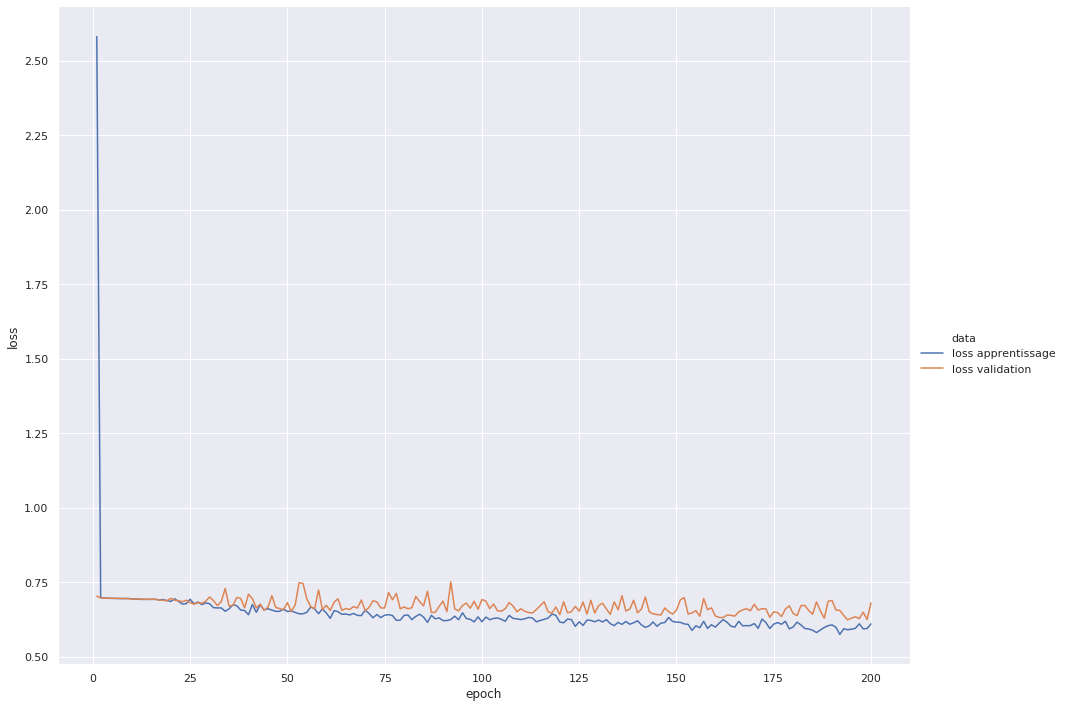

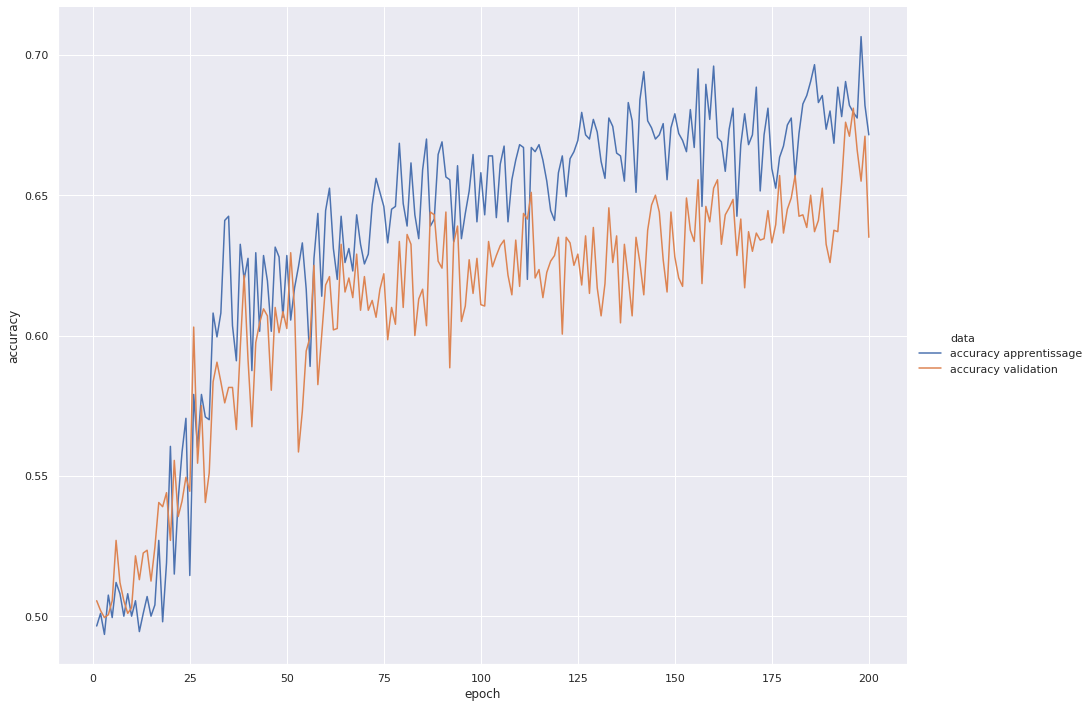

In [230]:
plot_loss_acc(h_reg_gen_200[0].history)

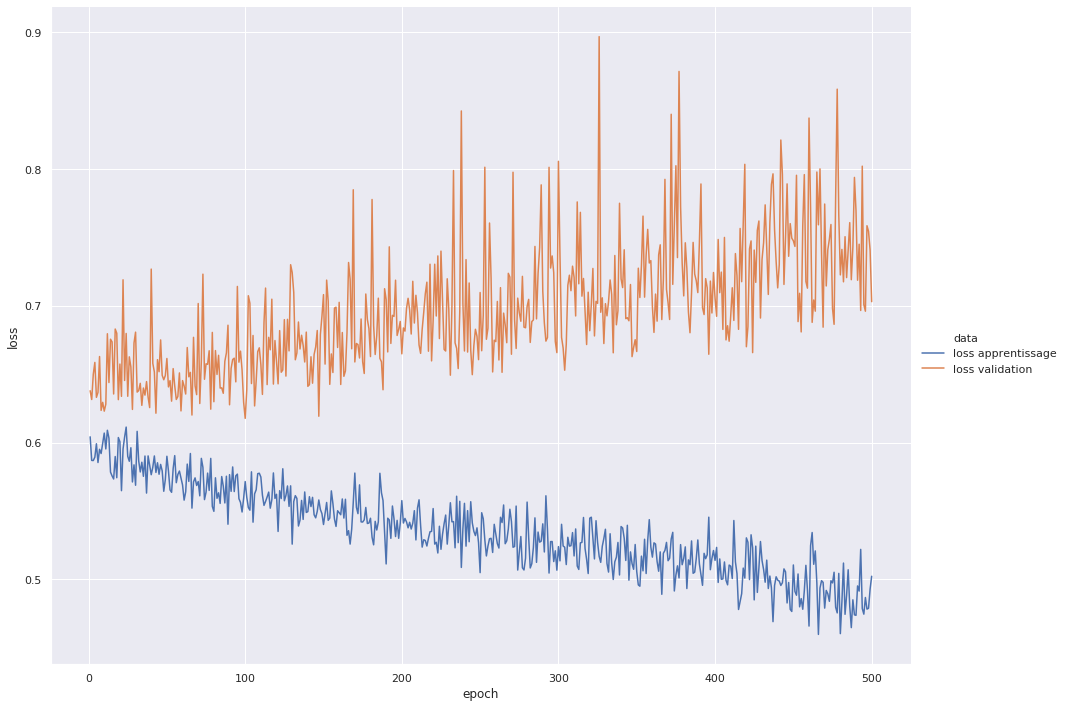

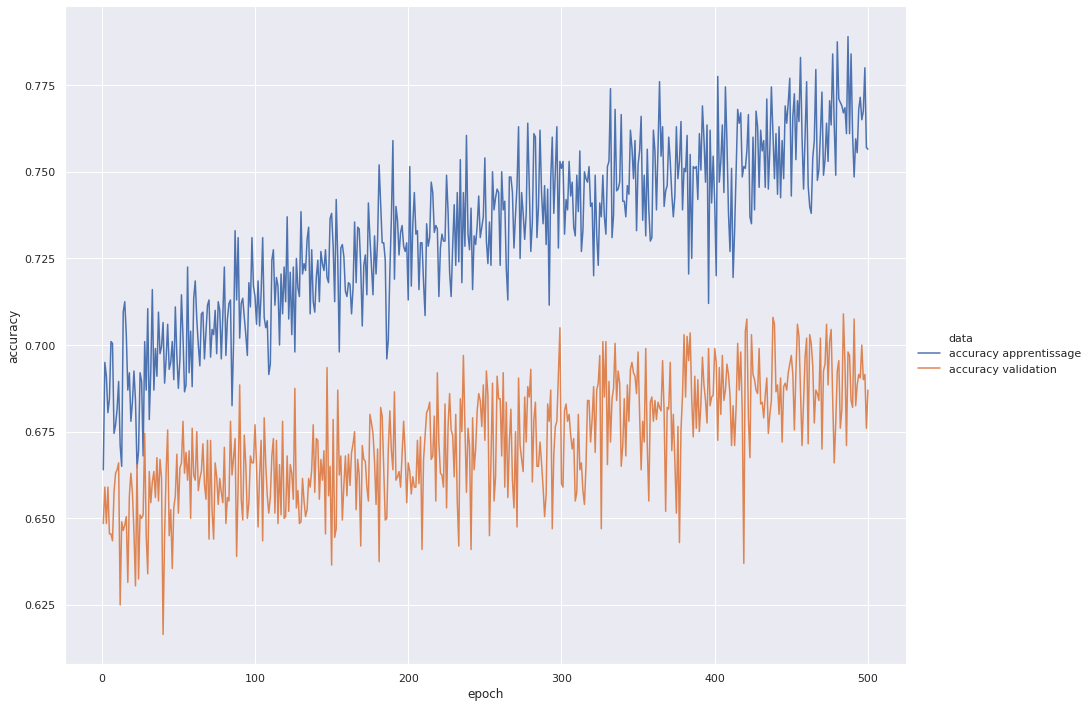

In [231]:
plot_loss_acc(h_reg_gen_500[0].history)

In [ ]:
early = EarlyStopping(monitor = "val_loss", mode = "min", patience = 7)
callbacks_list = [early]
history = model.fit(data_mat_3d_final, target_arr, 
    epochs=50, batch_size=25, verbose=2, 
    validation_split = 0.20,
    callbacks = callbacks_list)


In [199]:
# model.save(model_and_weights_filename) pour sauvegarder le model et les poids dans un même fichier hdf5
def save_model(model, model_filename="model.yaml", weights_filename="weights.h5"):
    model_yaml = model.to_yaml()
    with open(model_filename, "w") as yaml_file:
        yaml_file.write(model_yaml)
    model.save_weights(weights_filename)

In [200]:
from keras.models import model_from_yaml
def load_model(model_filename="model.yaml", weights_filename="weights.h5"):
    model= None
    with open(model_filename, 'r') as model_file:
        model = model_from_yaml(model_file.read())
        model.load_weights(weights_filename)
    return model

In [122]:
model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 124s 1us/step


# Utilisation directe d'un réseau déjà existant entrainé

In [55]:
from keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.resnet50 import ResNet50
model = VGG16()
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [62]:
# load an image from file
image = load_img('Data/Meeka/IMG_0031.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)

In [63]:
from keras.applications.vgg16 import decode_predictions
yhat = model.predict(image)
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label

[[('n02120505', 'grey_fox', 0.22315785),
  ('n02119789', 'kit_fox', 0.22091205),
  ('n02119022', 'red_fox', 0.21178795),
  ('n01877812', 'wallaby', 0.12684059),
  ('n02114855', 'coyote', 0.09074152)]]

**Exercices :** 

1. Utiliser plusieurs images pour identifier un animal prśent sur toutes ces images.
2. Utiliserd'autres modèles pré-entrainés
3. Utiliser plusieurs modèles pré-entrainés et plusieurs images pour réaliser une identification

## Transfert Learning

In [104]:
from keras import applications
from keras.layers import Input

def build_vgg16_transfert(width, height, depth, classes):
    (input_shape, chan_dim)=  ((depth, height, width), 1) if keras.backend.image_data_format() == "channels_first" \
    else ((height, width, depth), -1)
    new_input = Input(shape=input_shape)
    base_model = applications.VGG16(weights='imagenet', input_tensor = new_input, include_top=False)
    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    add_model.add(Dense(256, activation='relu'))
    add_model.add(Dense(2, activation='sigmoid'))
    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
    for layer in model.layers[:-5]:
        layer.trainable = False
    return model

model_transfert= build_vgg16_transfert(64, 64, 3, 2)
model_transfert.compile(loss='binary_crossentropy', optimizer=SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])

In [106]:
from keras import applications
from keras.layers import Input

def build_vgg16_transfert(width, height, depth, classes):
    (input_shape, chan_dim)=  ((depth, height, width), 1) if keras.backend.image_data_format() == "channels_first" \
    else ((height, width, depth), -1)
    new_input = Input(shape=input_shape)
    base_model = applications.VGG16(weights='imagenet', input_tensor = new_input, include_top=False)
    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    add_model.add(Dense(256, activation='relu'))
    add_model.add(Dense(2, activation='sigmoid'))
    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
    for layer in model.layers[:-5]:
        layer.trainable = False
    return model

model_transfert= build_vgg16_transfert(64, 64, 3, 2)
model_transfert.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [96]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [97]:
h_transfert= evaluate_model_with_generator(model,X,y, generator, 100)

Epoch 1/100
32/32 [==============================] - 37s 1s/step - loss: 0.4438 - accuracy: 0.8000 - val_loss: 0.4672 - val_accuracy: 0.7850
Epoch 2/100
32/32 [==============================] - 37s 1s/step - loss: 0.4468 - accuracy: 0.7845 - val_loss: 0.4671 - val_accuracy: 0.7855
Epoch 3/100
32/32 [==============================] - 36s 1s/step - loss: 0.4720 - accuracy: 0.7655 - val_loss: 0.4639 - val_accuracy: 0.7885
Epoch 4/100
32/32 [==============================] - 41s 1s/step - loss: 0.4509 - accuracy: 0.7795 - val_loss: 0.4528 - val_accuracy: 0.7830
Epoch 5/100
32/32 [==============================] - 42s 1s/step - loss: 0.4658 - accuracy: 0.7740 - val_loss: 0.4808 - val_accuracy: 0.7700
Epoch 6/100
32/32 [==============================] - 51s 2s/step - loss: 0.4345 - accuracy: 0.7955 - val_loss: 0.4715 - val_accuracy: 0.7760
Epoch 7/100
32/32 [==============================] - 41s 1s/step - loss: 0.4435 - accuracy: 0.7915 - val_loss: 0.4491 - val_accuracy: 0.7895
Epoch 8/100
3

Epoch 59/100
32/32 [==============================] - 39s 1s/step - loss: 0.3047 - accuracy: 0.8760 - val_loss: 0.4461 - val_accuracy: 0.7910
Epoch 60/100
32/32 [==============================] - 40s 1s/step - loss: 0.3041 - accuracy: 0.8675 - val_loss: 0.4293 - val_accuracy: 0.8020
Epoch 61/100
32/32 [==============================] - 39s 1s/step - loss: 0.2680 - accuracy: 0.8940 - val_loss: 0.4326 - val_accuracy: 0.8020
Epoch 62/100
32/32 [==============================] - 40s 1s/step - loss: 0.2954 - accuracy: 0.8755 - val_loss: 0.4586 - val_accuracy: 0.7820
Epoch 63/100
32/32 [==============================] - 39s 1s/step - loss: 0.2722 - accuracy: 0.8820 - val_loss: 0.4313 - val_accuracy: 0.8025
Epoch 64/100
32/32 [==============================] - 39s 1s/step - loss: 0.2961 - accuracy: 0.8815 - val_loss: 0.4593 - val_accuracy: 0.7835
Epoch 65/100
32/32 [==============================] - 40s 1s/step - loss: 0.2764 - accuracy: 0.8790 - val_loss: 0.4319 - val_accuracy: 0.7995
Epoch 

In [100]:
history_transfert= h_transfert[0].history
xx=range(1,len(history_transfert['loss'])+1)
h[0].history.keys()
(acc,val_acc)= ('acc','val_acc') if 'acc' in history.keys() else ('accuracy', 'val_accuracy')

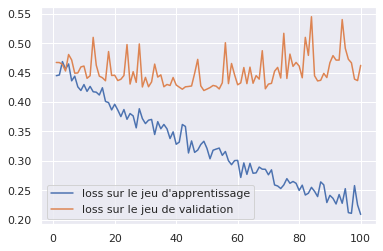

In [101]:
sns.lineplot(x=xx, y=history_transfert['loss'])
sns.lineplot(x=xx, y=history_transfert['val_loss'])
plt.legend(["loss sur le jeu d'apprentissage", "loss sur le jeu de validation"])

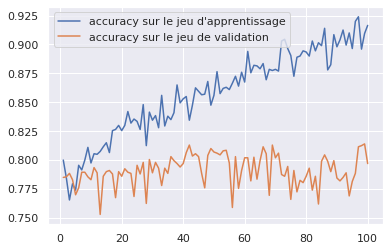

In [102]:
sns.lineplot(x=xx, y=history_transfert[acc])
sns.lineplot(x=xx, y=history_transfert[val_acc])
plt.legend(["accuracy sur le jeu d'apprentissage", "accuracy sur le jeu de validation"])

0        1
1        2
2        3
3        4
4        5
      ... 
395     96
396     97
397     98
398     99
399    100
Name: epoch, Length: 400, dtype: int64


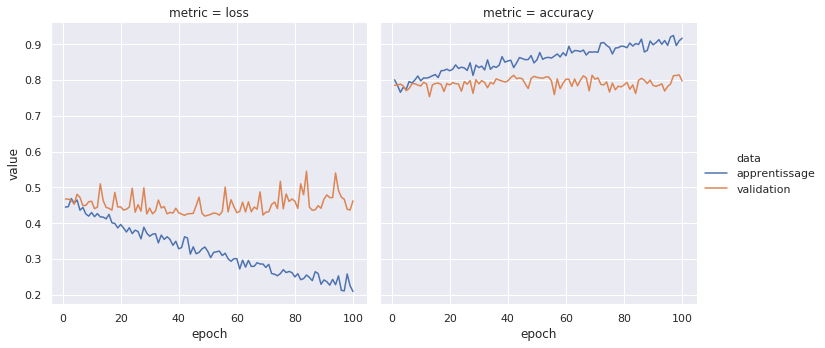

In [167]:
plot_loss_acc(history_transfert)

https://sthalles.github.io/keras-regularizer/

In [205]:
import os
import tempfile
from keras.models import model_from_json
from keras.regularizers import l2

def add_regularization(model, regularizer=l2(0.0001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

ModuleNotFoundError: No module named 'tf'

In [ ]:
def build_vgg16_transfert(width, height, depth, classes):
    (input_shape, chan_dim)=  ((depth, height, width), 1) if keras.backend.image_data_format() == "channels_first" \
    else ((height, width, depth), -1)
    new_input = Input(shape=input_shape)
    base_model = applications.VGG16(weights='imagenet', input_tensor = new_input, include_top=False)
    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    add_model.add(Dense(256, activation='relu'))
    add_model.add(Dense(2, activation='sigmoid'))
    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
    for layer in model.layers[:-5]:
        layer.trainable = False
    return model

model_transfert= build_vgg16_transfert(64, 64, 3, 2)
model_transfert.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

https://medium.com/tensorflow/introducing-bodypix-real-time-person-segmentation-in-the-browser-with-tensorflow-js-f1948126c2a0
https://storage.googleapis.com/tfjs-models/demos/body-pix/index.html
